In [38]:
!pip install neuralprophet

In [39]:
from neuralprophet import NeuralProphet

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

In [41]:
# Mount Google Drive
drive.mount('/content/drive')

# Path of folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/2024_09_13/'

# Get list of all CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to hold the dataframes
dfs = []

# Loop through the CSV files and read each one into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
data_selected = data[['Alarm Name', 'Alarm Location Info', 'First Occurred On', 'Site ID', 'Vendor', 'Domain', 'Device Type']]
data_selected.head(10)

,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
0,Cell Capability Degraded,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB
1,Cell Out of Service,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
2,Cell Out of Service,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
3,Cell Out of Service,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
4,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
5,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 10:46:25,KU0436,HUAWEI,Access,eGBTS
6,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
7,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
8,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB
9,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB


In [43]:
# prompt: get only alarms for site id PU0146

PU0146_alarms = data_selected[data_selected['Site ID'] == 'KU0436']
PU0146_alarms.head(10)



,Alarm Name,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type
0,Cell Capability Degraded,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB
1,Cell Out of Service,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
2,Cell Out of Service,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
3,Cell Out of Service,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS
4,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
5,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 10:46:25,KU0436,HUAWEI,Access,eGBTS
6,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
7,GSM Local Cell Unusable,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS
8,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB
9,Cell Unavailable,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB


In [44]:
# prompt: encode the Alarm name column  and rename that column as y

le = LabelEncoder()
PU0146_alarms['y'] = le.fit_transform(PU0146_alarms['Alarm Name'])
PU0146_alarms = PU0146_alarms.drop('Alarm Name', axis=1)
PU0146_alarms.head(10)

,Alarm Location Info,First Occurred On,Site ID,Vendor,Domain,Device Type,y
0,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB,12
1,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
2,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
3,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
4,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
5,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 10:46:25,KU0436,HUAWEI,Access,eGBTS,23
6,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
7,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
8,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14
9,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14


In [45]:
# prompt: give mapping of encoded value to alarm name  print line by line

for i, alarm_name in enumerate(le.classes_):
  print(f'{i}: {alarm_name}')

0: AC Failure
1: BB Discharge 95 percent DoD
2: BBU CPRI Interface Error
3: BSS_GCell-SDCCH_Drop_Rate_Cell_Huawei2G
4: BSS_LCell-RRC_Other_Setup_Suc_Rate
5: BSS_LCell-eRAB_Drop_Rate
6: BSS_LCell_QCI1_eRAB_Suc_Rate
7: Battery Deep Discharge Alarm
8: Board Software Auto-Supply Failure
9: CSL Fault
10: Carrier Configuration Error
11: Cell Blocked
12: Cell Capability Degraded
13: Cell Out of Service
14: Cell Unavailable
15: Communication Between NMS And NE Is Abnormal
16: DC Under Voltage
17: DNS Admin Alarm
18: Data Configuration Exceeding Licensed Limit
19: Door Open Alarm
20: ETH_LOS
21: External Clock Reference Problem
22: Fuse Failure Alarm
23: GSM Local Cell Unusable
24: HW_4G_Traffic_alarm
25: IP PM Activation Failure
26: IRAT_HO_SRVCC_Success_Rate
27: Licensed Feature Unusable
28: Load Fuse Broken
29: Mains Failure
30: Mains Failure Alarm
31: NE Is Disconnected
32: NE_COMMU_BREAK
33: NE_NOT_LOGIN
34: No Solar Generation
35: Phase L1 Over Voltage
36: RF Unit DC Input Power Failure
3

In [46]:
# prompt: rename first occured column as ds

PU0146_alarms = PU0146_alarms.rename(columns={'First Occurred On': 'ds'})
PU0146_alarms.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB,12
1,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
2,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
3,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
4,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
5,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 10:46:25,KU0436,HUAWEI,Access,eGBTS,23
6,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
7,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
8,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14
9,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14


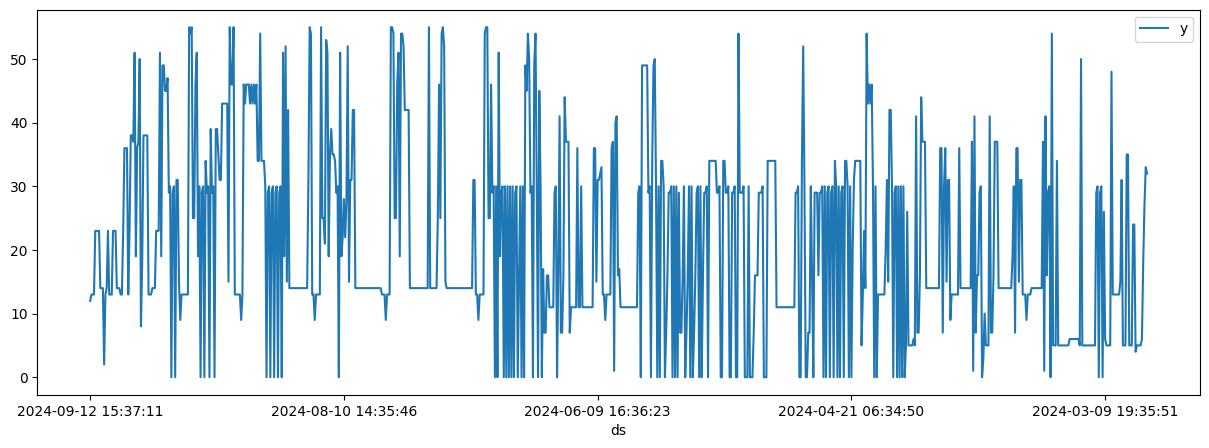

In [47]:
import pandas as pd

# Load the dataset from the CSV file using pandas
# df = pd.read_csv("https://github.com/ourownstory/neuralprophet-data/raw/main/kaggle-energy/datasets/tutorial01.csv")
# Plot the dataset, showing price (y column) over time (ds column)
plt = PU0146_alarms.plot(x="ds", y="y", figsize=(15, 5))

In [48]:
# prompt: sort accoding to ds column latest alarms

PU0146_alarms['ds'] = pd.to_datetime(PU0146_alarms['ds'])
PU0146_alarms = PU0146_alarms.sort_values(by='ds', ascending=False)
PU0146_alarms.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB,12
2,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
3,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
1,"Site Index=328, Cell Index=1520, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
4,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
6,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
7,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
8,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14
9,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14
10,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14


In [49]:
# prompt: drop rows with y is unknown

PU0146_alarms = PU0146_alarms[PU0146_alarms['y'] != 'Unknown']

In [50]:
# prompt: remove duplicates in ds

PU0146_alarms = PU0146_alarms.drop_duplicates(subset=['ds'])
PU0146_alarms.head(10)


,Alarm Location Info,ds,Site ID,Vendor,Domain,Device Type,y
0,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-12 15:37:11,KU0436,HUAWEI,Access,eNodeB,12
2,"Site Index=328, Cell Index=1519, Alarm Cause=O...",2024-09-07 12:06:37,KU0436,HUAWEI,Access,eGBTS,13
4,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 12:05:05,KU0436,HUAWEI,Access,eGBTS,23
8,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 12:05:02,KU0436,HUAWEI,Access,eNodeB,14
11,"Cabinet No.=0, Subrack No.=0, Slot No.=2, Port...",2024-09-07 11:36:57,KU0436,HUAWEI,Access,GBTS,2
12,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 11:36:17,KU0436,HUAWEI,Access,eGBTS,13
13,"eNodeB Function Name=Dandagamuwa-KU0436-BHP, L...",2024-09-07 11:34:47,KU0436,HUAWEI,Access,eNodeB,14
14,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 11:34:45,KU0436,HUAWEI,Access,eGBTS,23
16,"Site Index=328, Cell Index=1521, Alarm Cause=O...",2024-09-07 11:18:07,KU0436,HUAWEI,Access,eGBTS,13
18,"GBTS Function Name=Dandagamuwa-KU0436-DG, Loca...",2024-09-07 11:16:35,KU0436,HUAWEI,Access,eGBTS,23


In [51]:
# prompt: keep only ds and y columns

PU0146_alarms = PU0146_alarms[['ds', 'y']]
PU0146_alarms.head(10)


,ds,y
0,2024-09-12 15:37:11,12
2,2024-09-07 12:06:37,13
4,2024-09-07 12:05:05,23
8,2024-09-07 12:05:02,14
11,2024-09-07 11:36:57,2
12,2024-09-07 11:36:17,13
13,2024-09-07 11:34:47,14
14,2024-09-07 11:34:45,23
16,2024-09-07 11:18:07,13
18,2024-09-07 11:16:35,23


In [ ]:

# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

PU0146_alarms['ds'] = pd.to_datetime(PU0146_alarms['ds'])  # Ensure 'ds' is datetime
PU0146_alarms = PU0146_alarms.set_index('ds').resample('H').mean().reset_index()

# Create a NeuralProphet model with default parameters
# Set the learning rate and define other hyperparameters directly
m = NeuralProphet(
    learning_rate=0.005,          # Set the learning rate to 0.005
               # Sparsity in auto-regression (tune as needed)
    seasonality_mode='additive',  # Seasonality mode (choose between 'additive' or 'multiplicative')
)

# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(PU0146_alarms)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Create a new dataframe reaching 24*7 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

In [ ]:
# Create a new dataframe reaching 7 days into the future for our forecast
df_future = m.make_future_dataframe(PU0146_alarms, n_historic_predictions=True, periods=24*7)

# Predict the future
forecast = m.predict(df_future)

# Limit to 2 or 3 alarms per day
forecast['date'] = forecast['ds'].dt.date  # Extract the date from the datetime
daily_predictions = forecast.groupby('date').apply(lambda x: x.nlargest(2, 'yhat1')).reset_index(drop=True)

# Plot 'yhat1' as dots on top of the existing plot
plt.figure(figsize=(55, 25))  # Create a new figure with adjusted size
plt.scatter(daily_predictions['ds'], daily_predictions['yhat1'], color='red', label='yhat1 forecast')

# Add labels to data points
for i, row in daily_predictions.iterrows():
    plt.text(row['ds'], row['yhat1'], f'{row["yhat1"]:.2f}', fontsize=9, ha='right', va='bottom')

plt.xlabel('Date')
plt.ylabel('yhat1')
plt.title('Top 2 or 3 Alarms per Day')
plt.legend()
plt.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates
plt.xticks(daily_predictions['ds'], rotation=45, ha='right')

# Set y-axis ticks to show all yhat1 values
plt.yticks(daily_predictions['yhat1'])

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot


In [ ]:
# prompt: print the forecast alarms around value 13  with the date, print only the data after the latest day of initial data

# Filter forecast for alarms around value 13
filtered_forecast = forecast[(forecast['yhat1'] >= 12.8) & (forecast['yhat1'] <= 13.3)]

# Get the latest date in the original data
last_date = PU0146_alarms['ds'].max()

# Filter for dates after the last date in the original data
filtered_forecast = filtered_forecast[filtered_forecast['ds'] > last_date]

# Print the filtered forecast with date and yhat1
for index, row in filtered_forecast.iterrows():
  print(f"Date: {row['ds']}, Alarm (yhat1): {row['yhat1']:.2f}")


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Limit to 2 or 3 alarms per day
forecast['date'] = forecast['ds'].dt.date  # Extract the date from the datetime
daily_predictions = forecast.groupby('date').apply(lambda x: x.nlargest(3, 'yhat1')).reset_index(drop=True)

# Create a new figure with adjusted size
fig, ax = plt.subplots(figsize=(55, 25))

# Plot 'yhat1' as dots on top of the existing plot
ax.scatter(daily_predictions['ds'], daily_predictions['yhat1'], color='red', label='yhat1 forecast')

# Add labels to data points
for i, row in daily_predictions.iterrows():
    ax.text(row['ds'], row['yhat1'], f'{row["yhat1"]:.2f}', fontsize=9, ha='right', va='bottom')

ax.set_xlabel('Date')
ax.set_ylabel('yhat1')
ax.set_title('Top 2 or 3 Alarms per Day')
ax.legend()
ax.grid(True)  # Add grid lines for better readability

# Set x-axis ticks to show all dates
plt.xticks(daily_predictions['ds'], rotation=45, ha='right')

# Set y-axis ticks to show all yhat1 values
plt.yticks(daily_predictions['yhat1'])

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot

In [ ]:
# prompt: print the forecast data after the last day of actual data points  points with the date

# Find the last date in the original data
last_date = PU0146_alarms['ds'].max()

# Filter the forecast data to include only dates after the last date
forecast_future = forecast[forecast['ds'] > last_date]

# Print the forecast data with the date
for index, row in forecast_future.iterrows():
  print(f"Date: {row['ds'].date()}, yhat1: {row['yhat1']:.2f}")


In [ ]:
# Ensure that the forecast data and figure are valid before proceeding
if forecast is not None:
    # Extract the necessary columns for plotting
    ds_dates = forecast['ds']  # Time points
    yhat_values = forecast['yhat1']  # Forecasted values

    # Create a dot plot using plotly
    dot_plot = go.Figure(data=go.Scatter(
        x=ds_dates,
        y=yhat_values,
        mode='markers',  # Use 'markers' mode for dots
        marker=dict(color='blue', size=2),  # Customize the dot color and size
        name='Forecasted Values'
    ))

    # Customize the layout of the plot
    dot_plot.update_layout(
        title='Forecasted Values as Dot Plot',
        xaxis_title='Date',
        yaxis_title='Forecasted Value',
        height=500,
        width=1000,
    )

    # Show the plot
    dot_plot.show()
else:
    print("Warning: Forecast data is not available for plotting.")